# Dataset Loading

In [1]:
! pip install -q "flwr-datasets[vision]"

In [2]:
from flwr_datasets import FederatedDataset
from flwr_datasets.partitioner import IidPartitioner
from flwr_datasets.visualization import plot_label_distributions
from flwr_datasets.partitioner import DirichletPartitioner
from flwr_datasets.partitioner import PathologicalPartitioner

In [3]:
# User will enter dataset name, partitioner (it can be based on label, or skewness or by default IID partitioning),

def dataset_initialization(dataset_name="uoft-cs/cifar10", num_partitions=1, num_classes_per_partition=None, alpha=None, visualize=False):
    if num_classes_per_partition is not None:
        partitioner = PathologicalPartitioner(num_partitions=num_partitions, partition_by="label", num_classes_per_partition=num_classes_per_partition)
    elif alpha is not None:
        partitioner = DirichletPartitioner(num_partitions=num_partitions, partition_by="label", alpha=alpha, seed=42, min_partition_size=0)
    else:
        partitioner = IidPartitioner(num_partitions=num_partitions)

    fds = FederatedDataset(
        dataset= dataset_name, partitioners={"train": partitioner}
        )

    partitioner = fds.partitioners["train"]

    if visualize:
      fig, ax, df = plot_label_distributions(
        partitioner,
        label_name="label",
        plot_type="bar",
        size_unit="absolute",
        partition_id_axis="x",
        legend=True,
        verbose_labels=True,
        title="Per Partition Labels Distribution",
      )

    return fds, partitioner

In [4]:
def get_partition_params():
    """Prompt user for dataset partitioning parameters."""
    dataset_name = input("Enter dataset name: ").strip()
    num_partitions = int(input("Enter the number of partitions (positive integer): "))
    choice = input("Partition by 'label' or 'skewness' or 'none': ").strip().lower()
    params = {"dataset_name": dataset_name, "num_partitions": num_partitions, "num_classes_per_partition":None, "alpha":None}
    if choice == "label":
        params["num_classes_per_partition"] = int(input("Enter number of classes per partition (positive integer): "))
    elif choice == "skewness":
        params["alpha"] = float(input("Enter alpha value (positive float): "))
    elif choice == "none":
        pass
    else:
        raise ValueError("Invalid choice! Must be 'label' or 'skewness' or 'None'.")
    return params

Enter dataset name: uoft-cs/cifar10
Enter the number of partitions (positive integer): 10
Partition by 'label' or 'skewness' or 'none': none


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


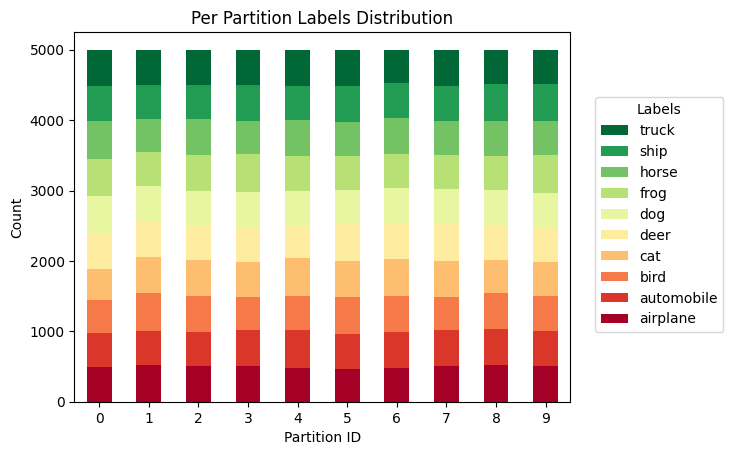

In [5]:
params = get_partition_params()
dataset=dataset_initialization(dataset_name=params["dataset_name"], num_partitions=params["num_partitions"], num_classes_per_partition=params["num_classes_per_partition"], alpha=params["alpha"], visualize=True)

In [6]:
print(type(dataset[0]))

<class 'flwr_datasets.federated_dataset.FederatedDataset'>


# Federated Learning Setup

## Data Preprocessing

In [7]:
!pip install -q flwr[simulation] flwr-datasets[vision] torch torchvision matplotlib

In [8]:
from collections import OrderedDict
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from datasets.utils.logging import disable_progress_bar
from torch.utils.data import DataLoader

import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Metrics, Context
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation
from flwr_datasets import FederatedDataset

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")
disable_progress_bar()

Training on cuda
Flower 1.14.0 / PyTorch 2.5.1+cu121


In [9]:
NUM_CLIENTS = 10
BATCH_SIZE = 32


def load_datasets(partition_id: int, fds: dataset):

    partition = fds.load_partition(partition_id)
    # Divide data on each node: 80% train, 20% test
    partition_train_test = partition.train_test_split(test_size=0.2, seed=42)
    pytorch_transforms = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )

    def apply_transforms(batch):
        # Instead of passing transforms to CIFAR10(..., transform=transform)
        # we will use this function to dataset.with_transform(apply_transforms)
        # The transforms object is exactly the same
        batch["img"] = [pytorch_transforms(img) for img in batch["img"]]
        return batch

    # Create train/val for each partition and wrap it into DataLoader
    partition_train_test = partition_train_test.with_transform(apply_transforms)
    trainloader = DataLoader(
        partition_train_test["train"], batch_size=BATCH_SIZE, shuffle=True
    )
    valloader = DataLoader(partition_train_test["test"], batch_size=BATCH_SIZE)
    testset = fds.load_split("test").with_transform(apply_transforms)
    testloader = DataLoader(testset, batch_size=BATCH_SIZE)
    return trainloader, valloader, testloader

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


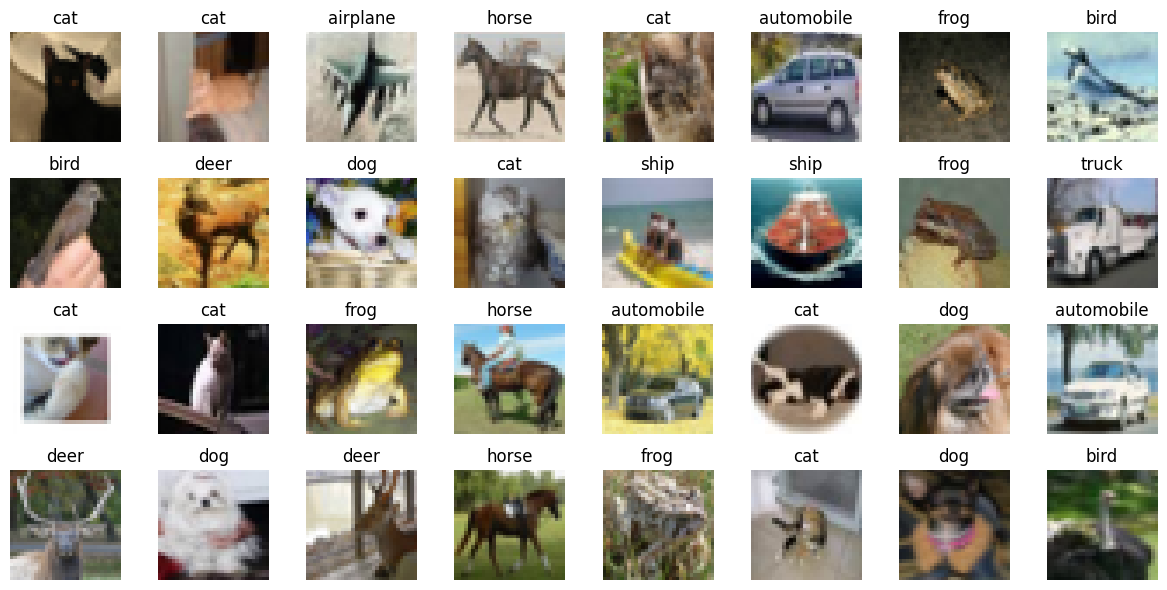

In [10]:
trainloader, _, _ = load_datasets(partition_id=0, fds=dataset[0])
batch = next(iter(trainloader))
images, labels = batch["img"], batch["label"]

# Reshape and convert images to a NumPy array
# matplotlib requires images with the shape (height, width, 3)
images = images.permute(0, 2, 3, 1).numpy()

# Denormalize
images = images / 2 + 0.5

# Create a figure and a grid of subplots
fig, axs = plt.subplots(4, 8, figsize=(12, 6))

# Loop over the images and plot them
for i, ax in enumerate(axs.flat):
    ax.imshow(images[i])
    ax.set_title(trainloader.dataset.features["label"].int2str([labels[i]])[0])
    ax.axis("off")

# Show the plot
fig.tight_layout()
plt.show()

## Custom Model

In [11]:
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Training and Testing

In [12]:
def train(net, trainloader, epochs: int, verbose=False):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:
            images, labels = batch["img"].to(DEVICE), batch["label"].to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["img"].to(DEVICE), batch["label"].to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

In [13]:
trainloader, valloader, testloader = load_datasets(partition_id=0, fds=dataset[0])
net = Net().to(DEVICE)

for epoch in range(5):
    train(net, trainloader, 1)
    loss, accuracy = test(net, valloader)
    print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")

loss, accuracy = test(net, testloader)
print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

Epoch 1: validation loss 0.06066431081295014, accuracy 0.309
Epoch 2: validation loss 0.054520474195480347, accuracy 0.395
Epoch 3: validation loss 0.05116436624526977, accuracy 0.409
Epoch 4: validation loss 0.05040922033786774, accuracy 0.419
Epoch 5: validation loss 0.04950681400299072, accuracy 0.436
Final test set performance:
	loss 0.05009985723495483
	accuracy 0.4067


In [14]:
def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)


def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

## Client Side

In [16]:
  class FlowerClient(NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=1)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

In [17]:
def client_fn(context: Context) -> Client:
    """Create a Flower client representing a single organization."""

    # Load model
    net = Net().to(DEVICE)

    # Load data (CIFAR-10)
    # Note: each client gets a different trainloader/valloader, so each client
    # will train and evaluate on their own unique data partition
    # Read the node_config to fetch data partition associated to this node
    partition_id = context.node_config["partition-id"]
    trainloader, valloader, _ = load_datasets(partition_id=partition_id, fds=dataset[0])

    # Create a single Flower client representing a single organization
    # FlowerClient is a subclass of NumPyClient, so we need to call .to_client()
    # to convert it to a subclass of `flwr.client.Client`
    return FlowerClient(net, trainloader, valloader).to_client()


# Create the ClientApp
client = ClientApp(client_fn=client_fn)

## Server Side

In [19]:
from typing import List, Tuple, Dict, Optional
from flwr.server.strategy import FedAvg
from flwr.common import Scalar

# Custom strategy to store loss, accuracy, and metrics
class CustomFedAvg(FedAvg):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.training_results = []  # To store training results
        self.evaluation_results = []  # To store evaluation results

    def aggregate_fit(
        self,
        rnd: int,
        results: List[Tuple[str, Dict[str, Scalar]]],
        failures: List[BaseException],
    ) -> Optional[Dict[str, Scalar]]:
        # Call the super method to get the aggregated parameters
        aggregated_parameters = super().aggregate_fit(rnd, results, failures)

        # Collect training loss and accuracy
        round_results = {
            "round": rnd,
            "metrics": [result[1] for result in results],
        }
        self.training_results.append(round_results)

        return aggregated_parameters

    def aggregate_evaluate(
        self,
        rnd: int,
        results: List[Tuple[str, Dict[str, Scalar]]],
        failures: List[BaseException],
    ) -> Optional[float]:
        # Call the super method to get the aggregated evaluation metric
        aggregated_metrics = super().aggregate_evaluate(rnd, results, failures)

        # Collect evaluation loss and accuracy
        round_results = {
            "round": rnd,
            "metrics": [result[1] for result in results],
        }
        self.evaluation_results.append(round_results)

        return aggregated_metrics


In [20]:
# Create the custom strategy
strategy = CustomFedAvg(
    fraction_fit=1.0,  # Sample 100% of available clients for training
    fraction_evaluate=0.5,  # Sample 50% of available clients for evaluation
    min_fit_clients=10,  # Never sample less than 10 clients for training
    min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
    min_available_clients=10,  # Wait until all 10 clients are available
)

In [21]:
# Server function
def server_fn(context: Context) -> ServerAppComponents:
    """Construct components that set the ServerApp behaviour."""
    config = ServerConfig(num_rounds=5)
    return ServerAppComponents(strategy=strategy, config=config)

# Create the ServerApp
server = ServerApp(server_fn=server_fn)

# Start Setup

In [22]:
# Specify the resources each of your clients need
# By default, each client will be allocated 1x CPU and 0x GPUs
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}

# When running on GPU, assign an entire GPU for each client
if DEVICE == "cuda":
    backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 1.0}}
    # Refer to our Flower framework documentation for more details about Flower simulations
    # and how to set up the `backend_config`

In [23]:
# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

DEBUG:flwr:Asyncio event loop already running.
INFO :      Starting Flower ServerApp, config: num_rounds=5, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=15631) 2025-01-15 16:53:23.569003: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=15631) 2025-01-15 16:53:23.588713: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=15631) 2025-01-15 16:53:23.597136: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=15631) 2025-01-15 16:53:24.890217: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warn